## Classification Model 

In this notebook I am creating a classification model to predict whether or not a company commited to netzero.    The notebook is structured as follow:
1. Section 1 - library and dataset preparation
2. Section 2 - model selction part 1; here I am creating a pipeline to evaluate which model perform better without gridsearching. Models with better perfomance will be passed in Section 3
3. Section 3 - model selection part 2; in this section I am gridsearching through the models selected in Section 2. The model that present best accuracy and recall scores is the one that will be selected for further tuning and saved for the streamlit app

## Section 1  - Import and dataframe preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,  AdaBoostClassifier


In [2]:
df = pd.read_csv('../data/output/msci_company_country.csv')

In [3]:
df = df.drop(columns=['scope_1_tonnes','scope_2_tonnes', 'all_emission', 'gics_sub_industry_name','Entity',
                       'agriculture', 'land_use_forestry', 'waste', 'industry','manufact_construction', 'transport', 
                 'electr_heat', 'buildings','fugitive_emission', 'other_fuel_combustion', 'aviation_shipping', 
                       'port_weight', 'returns', 'emissions_lucf','emissions_factor(kg/kwh)', 
                       'emissions_gdp(kg/$ppp)','emissions_in_trade', 'co2_oil', 'co2_cement', 
                       'co2_coal', 'co2_gas', 't_date' ]).copy()
#I want to predict only for company that are committing or not to netzero
df = df[df['net_zero_committed']!='not_taking_action']

In [4]:
#dummifying the categorical column
df_dummy  = pd.get_dummies(df, columns=['gics_sector_name',  'region',  'company_cap', 
                             'country_economy',  'target_status_class_year'])

In [5]:
#checking number of companies I will be doing the analysis for
len(df_dummy['fsym_id'].unique())

535

In [6]:
#now I can drop these last two columns for modeling
df_dummy.drop(columns=['fsym_id'], inplace=True)

## Section1 -  Model Selection Part 1

**Step 1** Assembling Predictors and looking at the null models

In [7]:
df_dummy1 = df_dummy.copy()

In [8]:
#assembling my features; scope 3 is different from 1 and 2 and thus it will still be a predictor
features1 = [col for col in df_dummy1.columns if col !=  'net_zero_committed']
X = df_dummy1[features1]
y = df_dummy1['net_zero_committed'].map({'Yes':1, 'No':0})
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
#Null model
df_dummy1['net_zero_committed'].value_counts(normalize=True)

No     0.576465
Yes    0.423535
Name: net_zero_committed, dtype: float64

In [10]:
len(X.columns)

26

**Step 2** Assembling classification Pipeline

In [11]:
#Assembling pipeline 
pipelines = [
    ('LogReg'        , (Pipeline([ ('LR'   , LogisticRegression(max_iter=1000)         )]))),
    ('DecTree'    , (Pipeline([ ('TREE' , DecisionTreeClassifier()    )]))),
    ('BagReg'     , (Pipeline([ ('BAG'  , BaggingClassifier()         )]))),
    ('RandFor'    , (Pipeline([ ('RAND' , RandomForestClassifier()    )]))),
    ('AdaBoost'     , (Pipeline([ ('ADA'  , AdaBoostClassifier()        )]))),
    ('KNN'     , (Pipeline([ ('sc' , StandardScaler())    ,('KNN'  , KNeighborsClassifier()  )]))),
]

**Step 3** Fitting and Scoring all models

In [12]:
for pipe_name, model in pipelines:
    print(pipe_name)
    model.fit(X_train, y_train)
    trainscore = round(model.score(X_train, y_train),3)
    testscore = round(model.score(X_test, y_test),3)
    crossval = round(cross_val_score(model, X_train, y_train).mean(),3)
    print(f'Train: {trainscore}, Test: {testscore}, CV: {crossval}')

LogReg
Train: 0.629, Test: 0.624, CV: 0.635
DecTree
Train: 1.0, Test: 0.869, CV: 0.86
BagReg
Train: 0.99, Test: 0.88, CV: 0.874
RandFor
Train: 1.0, Test: 0.888, CV: 0.884
AdaBoost
Train: 0.654, Test: 0.647, CV: 0.652
KNN
Train: 0.913, Test: 0.87, CV: 0.869


**Step 5** Predicting Emission and Evaluating The model

In [13]:
# 1 is someone eligible for our
for pipe_name, model in pipelines:
    print(pipe_name)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()
    print(f'precision score: {metrics.precision_score(y_test, pred)}')
    print(f'accuracy score: {metrics.accuracy_score(y_test, pred)}')
    print(f'recall score: {metrics.recall_score(y_test, pred)}')
    print(f'specificity score: {tn/(tn + fp)}')

LogReg
precision score: 0.5814977973568282
accuracy score: 0.6243705941591138
recall score: 0.4167324388318863
specificity score: 0.7780373831775701
DecTree
precision score: 0.8373729476153244
accuracy score: 0.8643840214837194
recall score: 0.8453038674033149
specificity score: 0.8785046728971962
BagReg
precision score: 0.8666127728375101
accuracy score: 0.879154078549849
recall score: 0.846093133385951
specificity score: 0.9036214953271028
RandFor
precision score: 0.86697965571205
accuracy score: 0.8895602551191675
recall score: 0.8745067087608525
specificity score: 0.9007009345794392
AdaBoost
precision score: 0.6172300981461287
accuracy score: 0.6468613628734474
recall score: 0.44672454617206
specificity score: 0.7949766355140186
KNN
precision score: 0.8342205323193916
accuracy score: 0.8697549513259483
recall score: 0.8658247829518547
specificity score: 0.8726635514018691


In [14]:
for pipe_name, model in pipelines:
    print(pipe_name)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_train = model.predict(X_train)
    print(f'f1 score test: {metrics.f1_score(y_test, pred)}')
    print(f'f1 score train: {metrics.f1_score(y_train, pred_train)}')

LogReg
f1 score test: 0.4855172413793103
f1 score train: 0.48381070983810714
DecTree
f1 score test: 0.8467267738141905
f1 score train: 1.0
BagReg
f1 score test: 0.8561122244488978
f1 score train: 0.9849192579741092
RandFor
f1 score test: 0.8662470495672698
f1 score train: 0.999602911978822
AdaBoost
f1 score test: 0.5183150183150184
f1 score train: 0.523603825979636
KNN
f1 score test: 0.849728892331526
f1 score train: 0.8977660972404731


## Section 2 - Model Selection Part 2

Based on the score obtained abvoe, I will be tunining the following three model:
1. Decision Tree
2. Bagged Decision Tree
3. Random Forest 
4. KNN

The model that will be presenting best accuracy while also minimizing recall (FN) is the one that I will be saving for the streamlit app

In [15]:
model_dt = Pipeline([ ('sc' , StandardScaler())    ,('dt'  , DecisionTreeClassifier(random_state=42) )])
model_bc = Pipeline([ ('sc' , StandardScaler())    ,('bc'  , BaggingClassifier(random_state=42)  )])
model_rf =Pipeline([ ('sc' , StandardScaler())    ,('rf'  , RandomForestClassifier(random_state=42)  )]) 
model_knn = Pipeline([ ('sc' , StandardScaler())    ,('KNN'  , KNeighborsClassifier()  )])

In [16]:
params_dt = {
    'dt__max_depth': [None, 2, 3],
    'dt__min_samples_split': [2, 3, 4],
    'dt__min_samples_leaf': [1, 2, 3],
    'dt__ccp_alpha': [0, 0.001, 0.1]
}
params_bc = {  
    
    'bc__max_samples':[1.0,2,3],
    'bc__max_features':[1.0, 3,4],
    'bc__bootstrap_features':[False,True]   
}
params_rf = {
    'rf__max_depth':[None, 3,4,5],
    'rf__max_features':['auto',4,5,6]
}
params_knn = {
    'KNN__n_neighbors':[5, 8,11, 15],
    'KNN__weights':['uniform','distance']
}

In [17]:
gs_dt = GridSearchCV(estimator = model_dt, 
                    param_grid=params_dt, 
                    scoring='accuracy', 
                    cv=5)

gs_bc = GridSearchCV(estimator = model_bc, 
                    param_grid=params_bc, 
                    scoring='accuracy', 
                    cv=5)

gs_rf = GridSearchCV(estimator = model_rf, 
                    param_grid=params_rf, 
                    scoring='accuracy', 
                    cv=5)

gs_knn = GridSearchCV(estimator = model_knn, 
                    param_grid=params_knn, 
                    scoring='accuracy', 
                    cv=5)

In [18]:
#Part of the code comes from this source: https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3
grids = [gs_dt, gs_bc, gs_rf ,gs_knn]
for pipe in grids:
    pipe.fit(X_train, y_train)
grid_dict = {0: 'DecisionTreeClassifier', 1: 'BaggingClassifier', 
             2: 'RandomForestClassifier', 3:'KNN'}
for i, model in enumerate(grids):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_train = model.predict(X_train)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()
    print(grid_dict[i])
    print(f'Accuracy Score: {round(metrics.accuracy_score(y_test, pred),5)}')
    print(f'Recall Score: {round(metrics.recall_score(y_test, pred),5)}')
    print(f'Specificity Score: {round(tn/(tn + fp),5)}')
#     print(f'Precision Score: {round(metrics.precision_score(y_test, pred),5)}')
#     print(f'F1 Score Test: {round(metrics.f1_score(y_test, pred),5)}')
#     print(f'F1 Score Train: {round(metrics.f1_score(y_train, pred_train),5)}')
    print(f'Best Params: {model.best_params_}')
    print()

DecisionTreeClassifier
Accuracy Score: 0.86673
Recall Score: 0.84451
Specificity Score: 0.88318
Best Params: {'dt__ccp_alpha': 0, 'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 4}

BaggingClassifier
Accuracy Score: 0.87714
Recall Score: 0.84294
Specificity Score: 0.90245
Best Params: {'bc__bootstrap_features': False, 'bc__max_features': 1.0, 'bc__max_samples': 1.0}

RandomForestClassifier
Accuracy Score: 0.88889
Recall Score: 0.87293
Specificity Score: 0.9007
Best Params: {'rf__max_depth': None, 'rf__max_features': 'auto'}

KNN
Accuracy Score: 0.87479
Recall Score: 0.86188
Specificity Score: 0.88435
Best Params: {'KNN__n_neighbors': 15, 'KNN__weights': 'distance'}



## Section 3 - Random Forest Further Tuning and  Evaluation

In [19]:
model_rf =Pipeline([ ('sc' , StandardScaler()),('rf'  , RandomForestClassifier(random_state=42) )]) 

In [20]:
params_rf = {
    'rf__max_depth':[None, 3,4],
    'rf__max_features':['auto',4,5],
    'rf__min_samples_split':[4,6,8], 
    'rf__max_leaf_nodes':[None,2,3],
    'rf__min_samples_leaf':[1,2,3],
    'rf__n_estimators':[60,70,80]}

gs_rf = GridSearchCV(estimator = model_rf, 
                    param_grid=params_rf, 
                    scoring='accuracy', 
                    cv=5)

In [21]:
model = gs_rf.fit(X_train, y_train)

In [22]:
pred = model.predict(X_test)
pred_train = model.predict(X_train)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()
print(f'Accuracy Score: {round(metrics.accuracy_score(y_test, pred),3)}')
print(f'Recall Score: {round(metrics.recall_score(y_test, pred),3)}')
print(f'Specificity Score: {round(tn/(tn + fp),3)}')
print(f'Best Params: {model.best_params_}')

Accuracy Score: 0.9
Recall Score: 0.889
Specificity Score: 0.908
Best Params: {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__max_leaf_nodes': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 8, 'rf__n_estimators': 70}


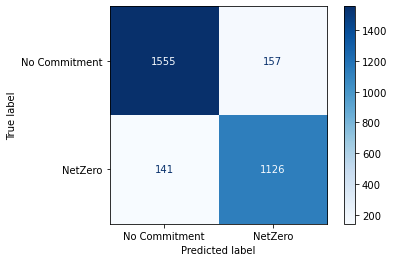

In [23]:
metrics.plot_confusion_matrix(model, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No Commitment', 'NetZero']);

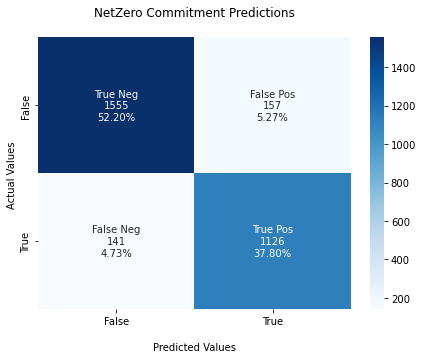

In [40]:
cf_matrix = metrics.confusion_matrix(y_test, pred)
#Source code: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/ 
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(7,5))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('NetZero Commitment Predictions\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.savefig('../images/confusion_matrix.png')
plt.show();



<Figure size 432x288 with 0 Axes>

In [25]:
model_4_eval = RandomForestClassifier(min_samples_split=8,n_estimators=80, 
                                      random_state=42, 
                                      max_features=4, 
                                      max_depth=None, 
                                      max_leaf_nodes=None, 
                                      min_samples_leaf=1) 
model = model_4_eval.fit(X_train, y_train)

predictors = pd.DataFrame(model.feature_importances_, X.columns).sort_values(by=0, ascending=False)
predictors

,0
scope1_2_emission,0.348846
scope_3_tonnes,0.311524
region_Europe,0.034207
gics_sector_name_Consumer Staples,0.021341
gics_sector_name_Industrials,0.021120
region_Asia/Pacific Ex Japan,0.020890
target_status_class_year_targets_set,0.019930
region_North America,0.019667
gics_sector_name_Financials,0.019131
region_Japan,0.018545


**Model Saving** Saving the random forest classifier for streamlit app

In [26]:
#saving the model fit for Streamlit
with open('../model/climate_commitment.pkl', 'wb') as f:
    model = pickle.dump(model, f)